# Testing simpler model

In [1]:
import numpy 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.5)

First let's plot the non-linear function

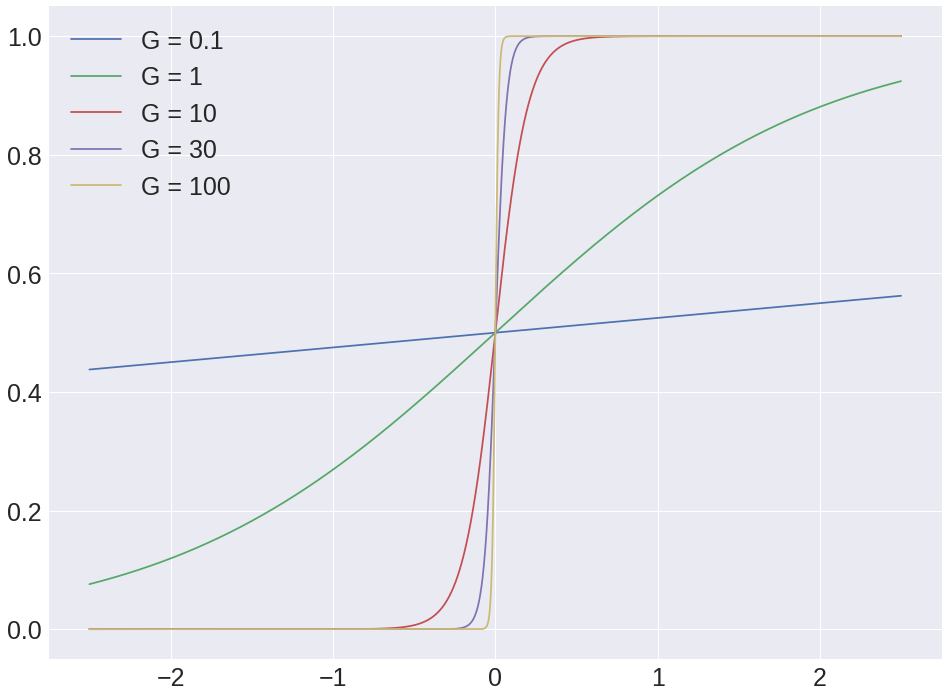

In [2]:
x = np.arange(-2.5, 2.5, 0.001)
G = 1.0 
G_list = [0.1, 1, 10, 30, 100]
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

def phi(x, G):    
    return 1.0/(1 + np.exp(-G * x))

for G in G_list:
    y = phi(x, G)    
    ax.plot(x, y, label='G = ' + str(G))

ax.legend();

## Now the equations

In [3]:
N = 10
T = 10.0

dt = 0.001
tau_m = 0.020
tau_z = 0.100
tau_a = 0.500

x = np.zeros(N)
z = np.zeros(N)
a = np.zeros(N)
x[0] = 1.0  # Initiail condition

# Lets design the matrix

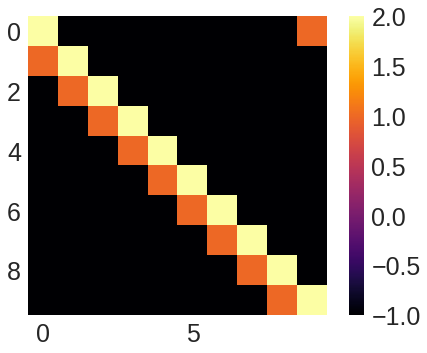

In [4]:
self_excitation = 2.0
inhbition = 1.0
transition = 1.0

def designed_matrix(N, self_excitation=1, transition=1, inhbition=1):
    w = np.ones((N, N)) * -inhbition
    for i in range(N - 1):
        w[i + 1, i + 1 ] = self_excitation
        w[i + 1, i] = transition
    
    w[0, 0] = self_excitation
    w[0, N - 1] = transition
    return w

w = designed_matrix(N, self_excitation, transition, inhbition)

plt.imshow(w, cmap='inferno')
plt.colorbar()
plt.grid()

In [5]:
N = 10
T = 5.0
T_cue = 0.200

dt = 0.0001
tau_m = 0.001
tau_z = 0.100
tau_a = 0.500

I = 0
G = 50.0
threshold = 0.5

self_excitation = 3.0
inhbition = 30.0
transition = 0.50
w = designed_matrix(N, self_excitation=self_excitation, transition=transition, inhbition=inhbition)

x = np.zeros(N)
current = np.zeros(N)
z = np.zeros(N)
a = np.zeros(N)
x[0] = 1.0  # Initial condition
z[0] = 0.0
 
x_history = []
z_history = []
current_history = []

steps = int(T / dt)
steps_cue = int(T_cue / dt)
for i in range(steps):
    x_history.append(np.copy(x))
    z_history.append(np.copy(z))
    current_history.append(np.copy(current))
    current = np.dot(w, z) - I
    x += (dt/tau_m) * (phi(G, current - threshold) - x)
    z += (dt/ tau_z) * (x - z)
    if i < steps_cue:
        x[0] = 1

x_history = np.array(x_history)
z_history = np.array(z_history)
current_history = np.array(current_history)

/home/heberto/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


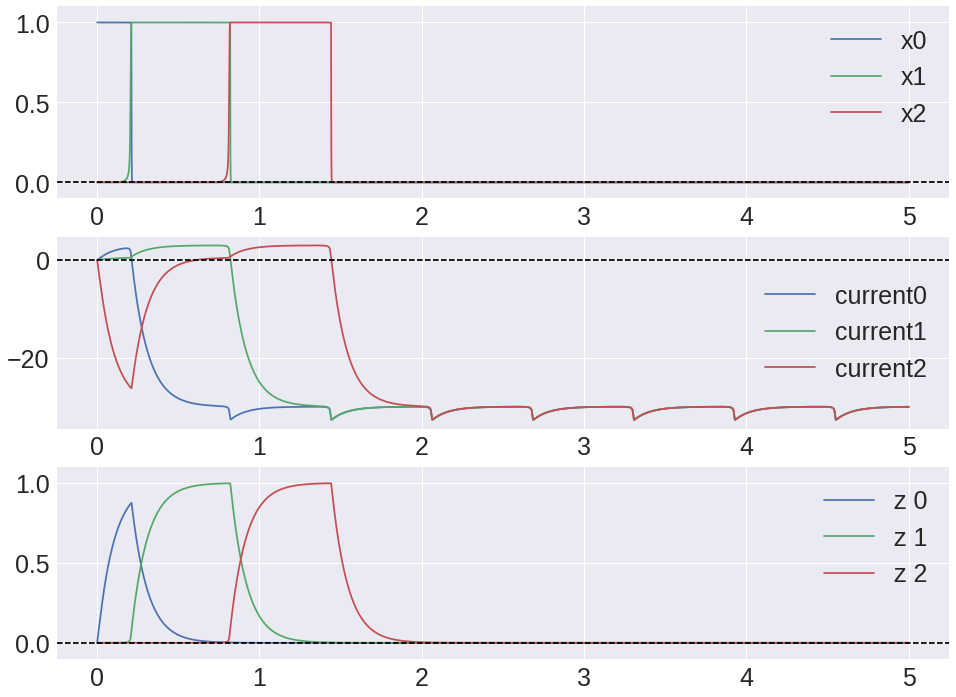

In [6]:
time = np.arange(0, T, dt)


fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

patterns = [0, 1, 2]
for pattern in patterns:
    ax1.plot(time, x_history[:, pattern], label='x' + str(pattern))
    ax2.plot(time, current_history[:, pattern], label='current' + str(pattern))
    ax3.plot(time, z_history[:, pattern], label='z ' + str(pattern))
    
ax1.axhline(0, ls='--', color='black')
ax1.legend();
ax1.set_ylim([-0.1, 1.1])
ax3.set_ylim([-0.1, 1.1])

ax2.axhline(0, ls='--', color='black')
ax2.legend();

ax3.axhline(0, ls='--', color='black')
ax3.legend();

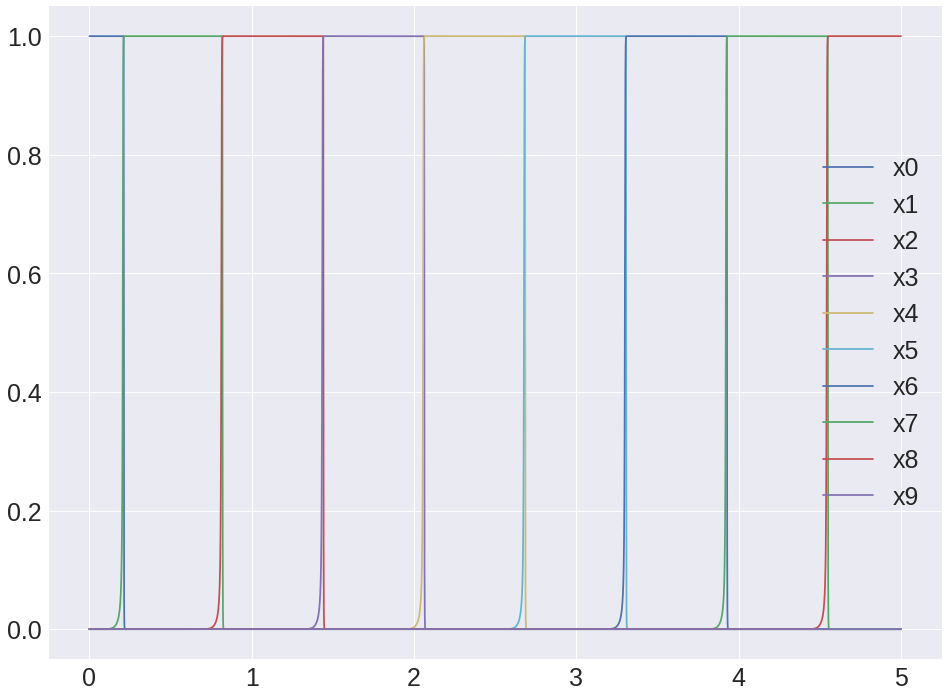

In [7]:
time = np.arange(0, T, dt)


fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(111)

patterns = [0, 1, 2, 3]
for pattern in range(N):
    ax1.plot(time, x_history[:, pattern], label='x' + str(pattern))
    
ax1.legend();

#### Getting the recall time

In [51]:
def get_recall_duration_for_pattern(x_history, pattern):
    

    x_indexes = np.where(x_history[:, pattern] > 0.5)[0]
    if len(x_indexes) > 0.0:
        start = x_indexes[0] * dt
        end = x_indexes[-1] * dt
        duration = end - start
    else:
        duration = np.nan
    return duration

In [56]:
def get_recall_duration_sequence(x_history):
    
    durations = []
    for pattern in range(x_history.shape[1]):
        duration = get_recall_duration_for_pattern(x_history, pattern)
        durations.append(duration)
        
    return np.nanmedian(durations[1:-1]), np.nanstd(durations[1:-1]), durations

In [17]:
get_recall_duration_sequence(x_history)

(0.50595999999999997,
 0.21164726882244422,
 [0.2114,
  0.6149,
  0.62909999999999999,
  0.62909999999999999,
  0.62919999999999998,
  0.62919999999999998,
  0.62909999999999977,
  0.62919999999999954,
  0.45840000000000014,
  0])

In [11]:
durations = []
for pattern in range(x_history.shape[1]):
    duration = get_recall_duration_for_pattern(x_history, pattern)
    durations.append(duration)


In [12]:
durations

[0.2114,
 0.6149,
 0.62909999999999999,
 0.62909999999999999,
 0.62919999999999998,
 0.62919999999999998,
 0.62909999999999977,
 0.62919999999999954,
 0.45840000000000014,
 0]

## Let's make the system a function

In [13]:
def run_network_recall(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue):

    x = np.zeros(N)
    current = np.zeros(N)
    z = np.zeros(N)
    a = np.zeros(N)
    x[I_cue] = 1.0  # Initial condition
    z[I_cue] = 0.0

    x_history = []
    z_history = []
    current_history = []

    steps = int(T / dt)
    steps_cue = int(T_cue / dt)
    for i in range(steps):
        x_history.append(np.copy(x))
        z_history.append(np.copy(z))
        current_history.append(np.copy(current))
        current = np.dot(w, z) - I
        x += (dt/tau_m) * (phi(G, current - threshold) - x)
        z += (dt/ tau_z) * (x - z)
        if i < steps_cue:
            x[0] = 1

    x_history = np.array(x_history)
    z_history = np.array(z_history)
    current_history = np.array(current_history)
    
    dic = {}
    dic['x'] = x_history
    dic['z'] = z_history
    dic['current'] = current_history
    
    return dic

In [165]:
N = 10
T = 10.0
T_cue = 0.200
I_cue = 0

dt = 0.0005
tau_m = 0.020
tau_z = 0.100
tau_a = 0.500

I = 0
G = 100.0
threshold = 0.5

self_excitation = 3.0
inhbition = 30.0
transition = 0.4335
w = designed_matrix(N, self_excitation=self_excitation, transition=transition, inhbition=inhbition)


dic = run_network_recall(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue)
x_history = dic['x']
z_history = dic['z']
current_history = dic['current']

/home/heberto/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


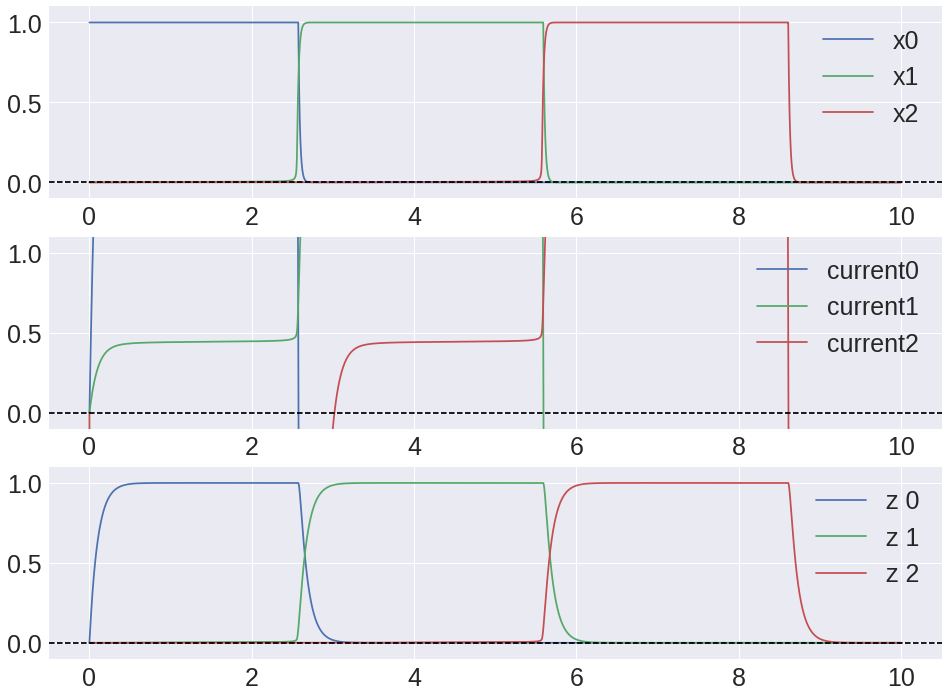

In [166]:
time = np.arange(0, T, dt)


fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

patterns = [0, 1, 2]
for pattern in patterns:
    ax1.plot(time, x_history[:, pattern], label='x' + str(pattern))
    ax2.plot(time, current_history[:, pattern], label='current' + str(pattern))
    ax3.plot(time, z_history[:, pattern], label='z ' + str(pattern))
    
ax1.axhline(0, ls='--', color='black')
ax1.legend();

ax1.set_ylim([-0.1, 1.1])
ax2.set_ylim([-0.1, 1.1])
ax3.set_ylim([-0.1, 1.1])

ax2.axhline(0, ls='--', color='black')
ax2.legend();

ax3.axhline(0, ls='--', color='black')
ax3.legend();

### Recall time testing as a function of transition

In [73]:
N = 10
T = 3.0
T_cue = 0.200
I_cue = 0

dt = 0.0001
tau_m = 0.020
tau_z = 0.100
tau_a = 0.500

I = 0
G = 50.0
threshold = 0.5

self_excitation = 3.0
inhbition = 30.0
transition = 0.50

transition_vector = np.arange(0.40, 0.8, 0.05)

mean_history = []
std_history = []
durations_history = []

for transition in transition_vector:
    print('transisition', transition)
    w = designed_matrix(N, self_excitation=self_excitation, transition=transition, inhbition=inhbition)
    dic = run_network_recall(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue)
    x_history = dic['x']
    z_history = dic['z']
    current_history = dic['current']

    aux  = get_recall_duration_sequence(x_history)
    mean, std, durations = aux
    
    mean_history.append(mean)
    std_history.append(std)
    durations_history.append(durations)

('transisition', 0.40000000000000002)


/home/heberto/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


('transisition', 0.45000000000000001)
('transisition', 0.5)
('transisition', 0.55000000000000004)
('transisition', 0.59999999999999998)
('transisition', 0.64999999999999991)
('transisition', 0.69999999999999996)
('transisition', 0.75)


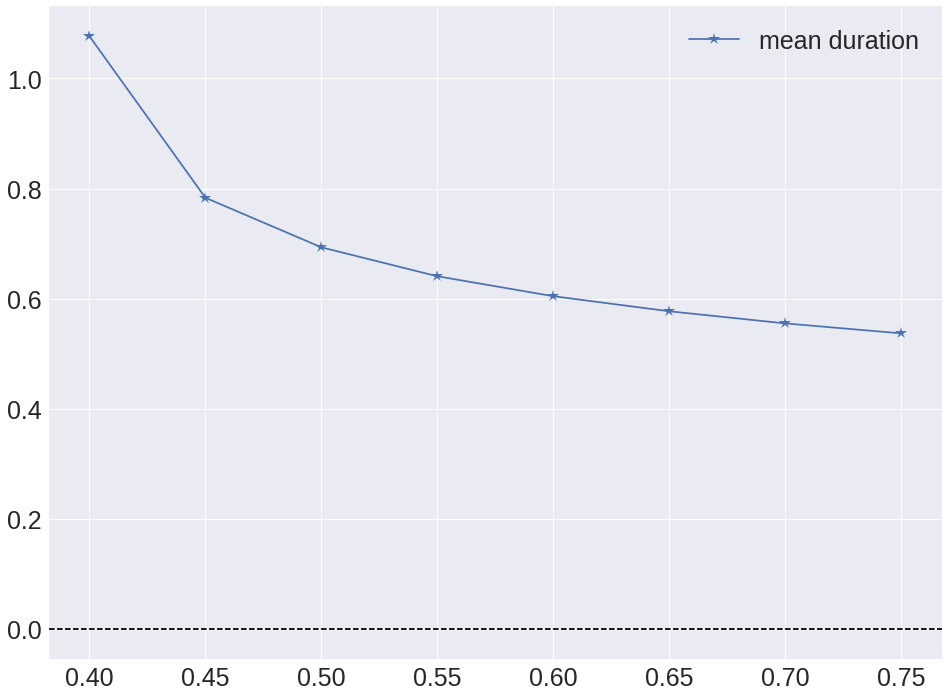

In [74]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ln, = ax.plot(transition_vector, mean_history, '*-', markersize=13, label='mean duration')


ax.axhline(0, ls='--', color='black')
ax.legend();

In [75]:
durations_history

[[0.61930000000000007,
  1.0768,
  1.0769000000000002,
  0.27700000000000014,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan],
 [0.33690000000000003,
  0.78139999999999998,
  0.78530000000000011,
  0.78529999999999989,
  0.38379999999999992,
  nan,
  nan,
  nan,
  nan,
  nan],
 [0.2535,
  0.68420000000000003,
  0.69340000000000002,
  0.69350000000000023,
  0.69350000000000023,
  0.076700000000000212,
  nan,
  nan,
  nan,
  nan],
 [0.21380000000000002,
  0.63180000000000003,
  0.64080000000000015,
  0.6408999999999998,
  0.64080000000000004,
  0.33369999999999989,
  nan,
  nan,
  nan,
  nan],
 [0.21380000000000002,
  0.62309999999999999,
  0.60470000000000002,
  0.60460000000000003,
  0.60460000000000003,
  0.48120000000000029,
  nan,
  nan,
  nan,
  nan],
 [0.21380000000000002,
  0.61529999999999996,
  0.57739999999999991,
  0.57720000000000016,
  0.57720000000000016,
  0.57719999999999994,
  0.036100000000000243,
  nan,
  nan,
  nan],
 [0.21380000000000002,
  0.60799999999999998,
  0.5554,


In [76]:
N = 10
T = 3.0
T_cue = 0.200
I_cue = 0

dt = 0.0001
tau_m = 0.020
tau_z = 0.100
tau_a = 0.500

I = 0
G = 50.0
threshold = 0.5

self_excitation = 3.0
inhbition = 30.0
transition = 0.50

transition_vector = np.arange(0.38, 0.6, 0.01)

mean_history = []
std_history = []
durations_history = []

for transition in transition_vector:
    print('transisition', transition)
    w = designed_matrix(N, self_excitation=self_excitation, transition=transition, inhbition=inhbition)
    dic = run_network_recall(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue)
    x_history = dic['x']
    z_history = dic['z']
    current_history = dic['current']

    aux  = get_recall_duration_sequence(x_history)
    mean, std, durations = aux
    
    mean_history.append(mean)
    std_history.append(std)
    durations_history.append(durations)

('transisition', 0.38)


/home/heberto/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


('transisition', 0.39000000000000001)
('transisition', 0.40000000000000002)
('transisition', 0.41000000000000003)
('transisition', 0.42000000000000004)
('transisition', 0.43000000000000005)
('transisition', 0.44000000000000006)
('transisition', 0.45000000000000007)
('transisition', 0.46000000000000008)
('transisition', 0.47000000000000008)
('transisition', 0.48000000000000009)
('transisition', 0.4900000000000001)
('transisition', 0.50000000000000011)
('transisition', 0.51000000000000012)
('transisition', 0.52000000000000013)
('transisition', 0.53000000000000014)
('transisition', 0.54000000000000015)
('transisition', 0.55000000000000016)
('transisition', 0.56000000000000016)
('transisition', 0.57000000000000017)
('transisition', 0.58000000000000018)
('transisition', 0.59000000000000019)


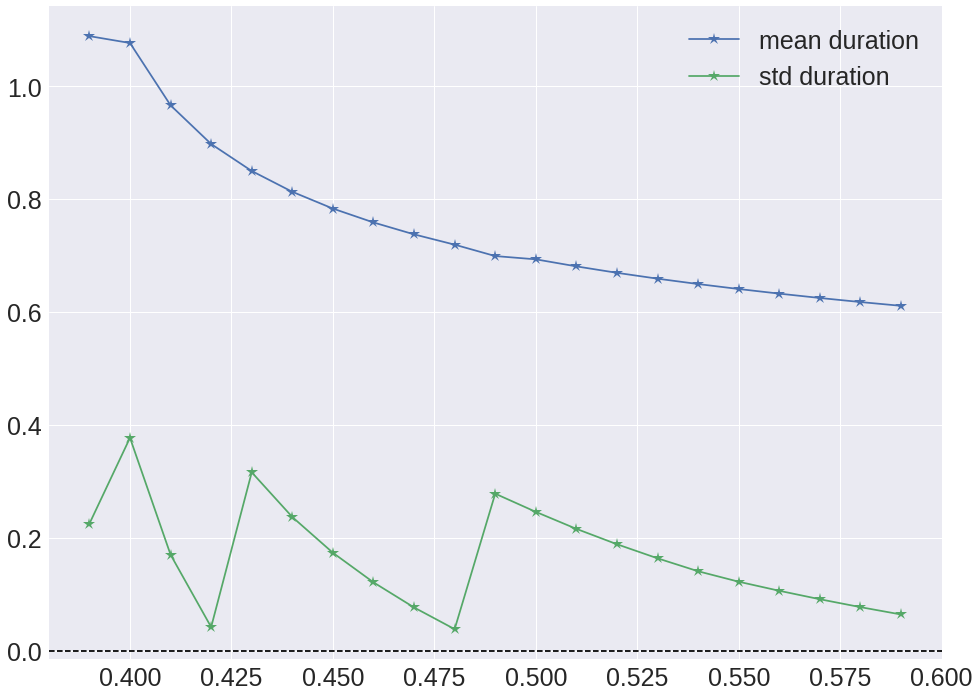

In [77]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ln, = ax.plot(transition_vector, mean_history, '*-', markersize=13, label='mean duration')
ln, = ax.plot(transition_vector, std_history, '*-', markersize=13, label='std duration')

ax.axhline(0, ls='--', color='black')
ax.legend();

Theoretical curve

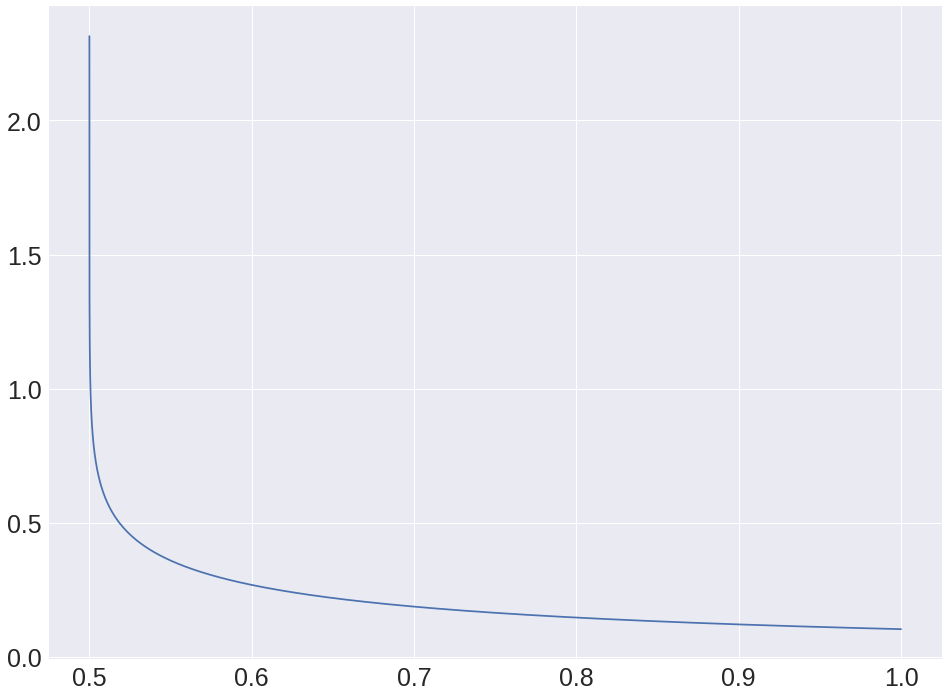

In [108]:
transition_vector = np.arange(0.5000001, 1.0, 0.0000001)

tau_z = 0.150
threshold = 0.50
x = tau_z * np.log(transition_vector / (transition_vector - threshold))

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(transition_vector, x);

(0, 1)

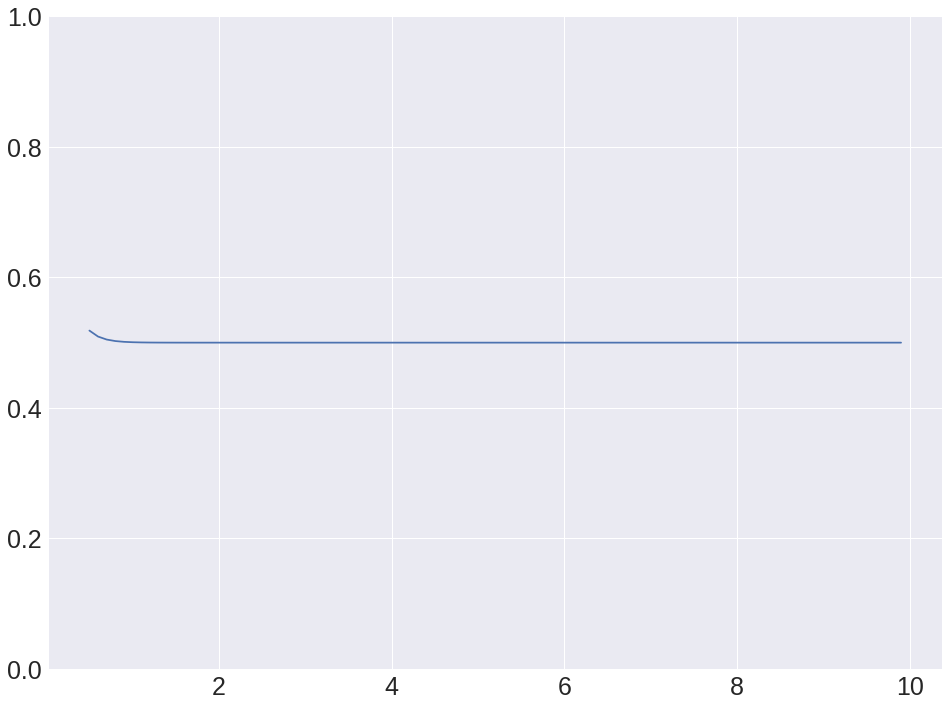

In [116]:
x = np.arange(0.5, 10, 0.1)
t = threshold / (1 - np.exp(-x / tau_z))
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(x, t)

ax.set_ylim([0, 1])